....................

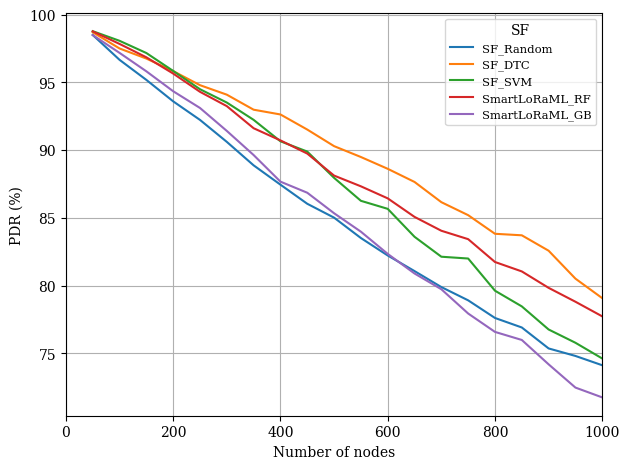

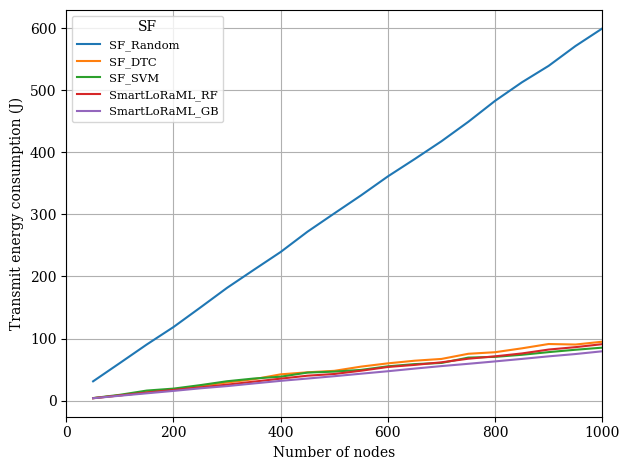

In [1]:
import random
import sys
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from topology import Topology
from simulation import Simulation
from simulation import SimulationResult
from packet import PacketSf
from sklearn.ensemble import RandomForestClassifier

random.seed(42)  # for now seed is constant


class SimulationFigure():
    def __init__(self, x_axis, plot_names):
        self.x_axis = x_axis
        self.plot_names = plot_names
        self.plot_data = {}
        for plot_name in self.plot_names:
            self.plot_data[plot_name] = []

    def get_plot(self, xlabel, ylabel, ylim_bottom=None, ylim_top=None, xlim_left=None, xlim_right=None):
        plt.figure()
        for plot_name in self.plot_names:
            plt.plot(self.x_axis, self.plot_data[plot_name], label=plot_name)

        if ylim_bottom is not None:
            plt.ylim(bottom=ylim_bottom)
        if ylim_top is not None:
            plt.ylim(top=ylim_top)
        if xlim_left is not None:
            plt.xlim(left=xlim_left)
        if xlim_right is not None:
            plt.xlim(right=xlim_right)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.tight_layout()



def plot_prediction(number_of_nodes_list, averaging, topology_radius, number_of_gws, packet_rate, packet_size, simulation_duration, traffic_type):
    prediction_name_list = [PacketSf.SF_Random.name, 'SF_DTC', 'SF_SVM', 'SmartLoRaML_RF', 'SmartLoRaML_GB'] # Adding GB to the list
    prediction_pdr_figure = SimulationFigure(number_of_nodes_list, prediction_name_list)
    prediction_energy_figure = SimulationFigure(number_of_nodes_list, prediction_name_list)

    for number_of_nodes in number_of_nodes_list:
        random_simulation_result_sum = SimulationResult()
        prediction_dt_simulation_result_sum = SimulationResult()
        prediction_svm_simulation_result_sum = SimulationResult()
        prediction_rf_simulation_result_sum = SimulationResult()
        prediction_gb_simulation_result_sum = SimulationResult() # Adding a result for Gradient Boosting
       
        sys.stdout.write('.')
        sys.stdout.flush()
       
        topology = Topology.create_random_topology(number_of_nodes=number_of_nodes, radius=topology_radius, number_of_gws=number_of_gws, node_traffic_proportions=traffic_type)

        for repeat in range(averaging):
            simulation = Simulation(topology=topology, packet_rate=packet_rate, packet_size=packet_size, simulation_duration=simulation_duration, sf=PacketSf.SF_Random)
            random_simulation_result_sum += simulation.run()

            X_train, X_test, y_train, y_test = simulation.get_training_data(test_size=0.2)

            # Decision Tree
            DT_classifier = DecisionTreeClassifier(class_weight='balanced')
            DT_classifier.fit(X_train, y_train)

            # Support Vector Machine
            SVM_classifier = svm.SVC(class_weight='balanced', gamma='auto')
            SVM_classifier.fit(X_train, y_train)

            # Random Forest
            RF_classifier = RandomForestClassifier(class_weight='balanced')
            RF_classifier.fit(X_train, y_train)

            # Gradient Boosting
            GB_classifier = GradientBoostingClassifier()
            GB_classifier.fit(X_train, y_train)

            # SF_Smart with Decision Tree predictor
            simulation = Simulation(topology=topology, packet_rate=packet_rate, packet_size=packet_size, simulation_duration=simulation_duration, sf=PacketSf.SF_Smart, sfPredictor=DT_classifier.predict)
            prediction_dt_simulation_result_sum += simulation.run()

            # SF_Smart with SVM predictor
            simulation = Simulation(topology=topology, packet_rate=packet_rate, packet_size=packet_size, simulation_duration=simulation_duration, sf=PacketSf.SF_Smart, sfPredictor=SVM_classifier.predict)
            prediction_svm_simulation_result_sum += simulation.run()

            # SF_Smart with Random Forest predictor
            simulation = Simulation(topology=topology, packet_rate=packet_rate, packet_size=packet_size, simulation_duration=simulation_duration, sf=PacketSf.SF_Smart, sfPredictor=RF_classifier.predict)
            prediction_rf_simulation_result_sum += simulation.run()

            # SF_Smart with Gradient Boosting predictor
            simulation = Simulation(topology=topology, packet_rate=packet_rate, packet_size=packet_size, simulation_duration=simulation_duration, sf=PacketSf.SF_Smart, sfPredictor=GB_classifier.predict)
            prediction_gb_simulation_result_sum += simulation.run()

        # Update figures
        prediction_pdr_figure.plot_data[PacketSf.SF_Random.name].append(float(random_simulation_result_sum.pdr) / averaging)
        prediction_pdr_figure.plot_data['SF_DTC'].append(float(prediction_dt_simulation_result_sum.pdr) / averaging)
        prediction_pdr_figure.plot_data['SF_SVM'].append(float(prediction_svm_simulation_result_sum.pdr) / averaging)
        prediction_pdr_figure.plot_data['SmartLoRaML_RF'].append(float(prediction_rf_simulation_result_sum.pdr) / averaging)
        prediction_pdr_figure.plot_data['SmartLoRaML_GB'].append(float(prediction_gb_simulation_result_sum.pdr) / averaging)

        prediction_energy_figure.plot_data[PacketSf.SF_Random.name].append(float(random_simulation_result_sum.txEnergyConsumption) / averaging)
        prediction_energy_figure.plot_data['SF_DTC'].append(float(prediction_dt_simulation_result_sum.txEnergyConsumption) / averaging)
        prediction_energy_figure.plot_data['SF_SVM'].append(float(prediction_svm_simulation_result_sum.txEnergyConsumption) / averaging)
        prediction_energy_figure.plot_data['SmartLoRaML_RF'].append(float(prediction_rf_simulation_result_sum.txEnergyConsumption) / averaging)
        prediction_energy_figure.plot_data['SmartLoRaML_GB'].append(float(prediction_gb_simulation_result_sum.txEnergyConsumption) / averaging)

    # Plot PDR figure
    prediction_pdr_figure.get_plot(xlabel='Number of nodes', ylabel='PDR (%)', xlim_left=0, xlim_right=1000)
    plt.legend(loc='upper right', fontsize='small', title='SF')
    plt.savefig('output/prediction_pdr_r{}_g{}_p{}_s{}.png'.format(topology_radius, number_of_gws, packet_rate, simulation_duration), dpi=200, transparent=True)

    # Plot Energy Consumption figure
    prediction_energy_figure.get_plot(xlabel='Number of nodes', ylabel='Transmit energy consumption (J)', xlim_left=0, xlim_right=1000)
    plt.legend(loc='upper left', fontsize='small', title='SF')
    plt.savefig('output/prediction_energy_r{}_g{}_p{}_s{}.png'.format(topology_radius, number_of_gws, packet_rate, simulation_duration), dpi=200, transparent=True)




# All units are SI base units
TOPOLOGY_RADIUS = 3000  # meters
NUMBER_OF_GWS = 1
PRED_TOPOLOGY_RADIUS = 5000  # meters
PRED_NUMBER_OF_GWS = 3
SIMULATION_DURATION = 3600  # seconds
PACKET_RATE = 0.01  # per second
PACKET_SIZE = 60  # bytes, header + payload, 13 + max(51 to 222)
TRAFFIC_TYPE = (1, 0)  # poisson, periodic
AVERAGING = 5
NUMBER_OF_NODES_LIST = range(50, 1001, 50)



plot_prediction(number_of_nodes_list=NUMBER_OF_NODES_LIST,
        averaging=AVERAGING,
        topology_radius=PRED_TOPOLOGY_RADIUS,
        number_of_gws=PRED_NUMBER_OF_GWS,
        packet_rate=PACKET_RATE,
        packet_size=PACKET_SIZE,
        simulation_duration=SIMULATION_DURATION,
        traffic_type=TRAFFIC_TYPE)
